In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!unzip '/content/drive/MyDrive/Funny-models-and-scripts-3.Machine_learning-4.neural_networks-1.%20rt_webcam_class_PyTorch.zip'

In [3]:
#Download the required libraries
from __future__ import print_function, division

import numpy as np
import torch
import torchvision
import os
import copy
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.onnx
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

%matplotlib inline

plt.ion()   # interactive moden

In [4]:
#get address
data_dir="/content/drive/MyDrive/datasets/"

#Create function to get your(my) images dataset and resize it to size for model
def get_dataset(data_dir, data_transforms):

    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


In [6]:
riterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cpu")

**Transer Learning**

pretrained model Renset18 train datasets

In [7]:
#Data scaled and normalization for training and testing for resnet18
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
trainloader, testloader, classes, dataset_sizes=get_dataset(data_dir, data_transforms)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")

Classes:  ['arial', 'calibri', 'times new roman', 'verdana']
The datasest have:  {'train': 414, 'test': 134}  images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
# Create new image show function for new transofration 
def imshow_resNet18(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


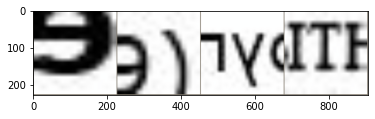

arial verdana verdana times new roman


In [10]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
#images, labels = dataiter.next()

# show images
imshow_resNet18(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Функция обучения модели

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Параметры для обучения модели

In [12]:
# Let's prepare the parameters for training the model
dataloaders = {'train': trainloader, 'test': testloader}
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Обучение модели

In [13]:
#Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.2345 Acc: 0.4710
test Loss: 0.7502 Acc: 0.6940

Epoch 1/24
----------
train Loss: 0.9887 Acc: 0.6159
test Loss: 0.7703 Acc: 0.7090

Epoch 2/24
----------
train Loss: 0.9011 Acc: 0.6643
test Loss: 0.7492 Acc: 0.7090

Epoch 3/24
----------
train Loss: 0.7032 Acc: 0.7319
test Loss: 0.9087 Acc: 0.6642

Epoch 4/24
----------
train Loss: 0.5956 Acc: 0.7802
test Loss: 0.6494 Acc: 0.8060

Epoch 5/24
----------
train Loss: 0.5630 Acc: 0.7874
test Loss: 0.6729 Acc: 0.7910

Epoch 6/24
----------
train Loss: 0.4379 Acc: 0.8406
test Loss: 0.5492 Acc: 0.7910

Epoch 7/24
----------
train Loss: 0.3859 Acc: 0.8696
test Loss: 0.5595 Acc: 0.7910

Epoch 8/24
----------
train Loss: 0.3417 Acc: 0.8744
test Loss: 0.5413 Acc: 0.8284

Epoch 9/24
----------
train Loss: 0.3085 Acc: 0.8889
test Loss: 0.5131 Acc: 0.8284

Epoch 10/24
----------
train Loss: 0.3547 Acc: 0.8768
test Loss: 0.5636 Acc: 0.8134

Epoch 11/24
----------
train Loss: 0.2617 Acc: 0.9106
test Loss: 0.5292 Acc: 0.8284

Epoch 12/24


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 2.8578, -0.7629,  0.5765, -2.8579])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.4799, -3.4213, -1.3524,  4.7460])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 2.3588, -0.4446,  2.0036, -3.3414])
Predict class - verdana, real class - calibri, probability (arial,calibri) - tensor([ 0.1197,  1.9881, -5.4363,  2.1183])


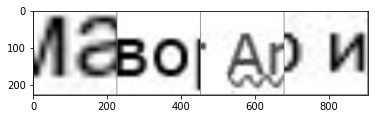

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.3390, -4.0363, -1.4486,  6.4473])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 4.1727,  0.3805,  4.3102, -7.2073])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.2070, -0.2978, -3.6683,  7.2292])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.5276,  5.0790, -0.3354, -5.4172])


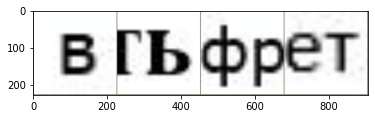

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 3.5097, -0.2560,  0.3186, -3.2736])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.1441, -0.3580, -5.3519,  4.3598])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.3416,  4.0469,  1.6664, -6.7459])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-1.8190,  6.8007, -5.1765, -0.2292])


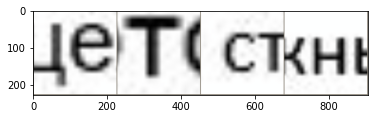

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.8505, -4.0999, -0.4940,  5.9779])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 0.7646, -0.0344,  0.4368, -1.4912])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.1368, -2.0635,  9.5196, -3.7237])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.2230, -3.3545,  7.0032, -1.6852])


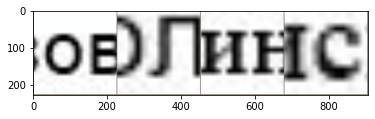

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-0.2719, -3.3763,  6.3343, -2.3033])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.5901,  1.4951, -5.0633,  2.2660])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.7660,  3.5290, -0.2173, -5.3075])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.4793,  1.1878, -3.4201, -2.6672])


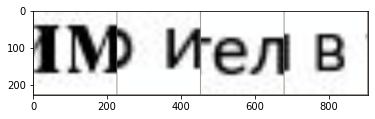

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.4962, -1.8343,  1.9402, -4.1126])
Predict class - arial, real class - times new roman, probability (arial,calibri) - tensor([ 3.5343, -1.1941,  2.8599, -4.6805])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.2098,  5.4534, -0.2985, -7.0514])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.4295, -1.7835, -2.5829,  5.6249])


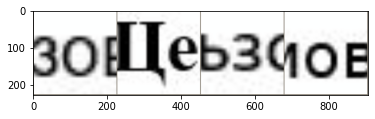

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.7778,  2.8103, -2.9086, -1.2693])
Predict class - calibri, real class - verdana, probability (arial,calibri) - tensor([ 0.4128,  1.2180, -0.9048, -0.1074])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-4.6564, -2.1971, -2.2618,  8.1536])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.5140, -3.4144,  8.3322, -1.6785])


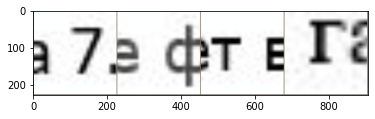

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.8371, -2.2006,  6.5505, -1.5324])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.7533,  1.1456, -7.3170,  7.3577])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 4.5090,  1.3557, -3.8049, -1.8569])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.8092, -2.2926,  4.2193, -0.2464])


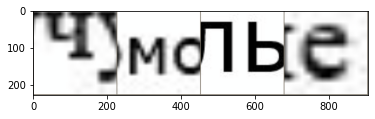

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 1.2331, -2.2820,  8.6300, -6.2061])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 3.4037,  2.8278,  1.0402, -6.2113])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 1.8036,  0.7208, -1.9578, -1.3246])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.8428,  5.7750, -3.6079, -3.1953])


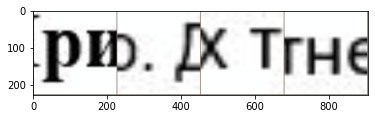

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 2.3995,  1.4333,  5.1824, -8.1767])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-0.3220,  0.6580,  3.8356, -2.8105])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.5969,  3.4718, -2.3779, -3.5046])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.2074,  1.6501, -3.3491,  0.9246])


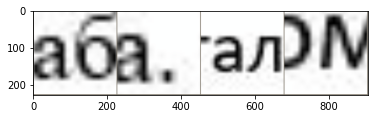

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.6012,  4.5029,  1.1063, -5.4711])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-2.7166,  4.6473, -1.6311, -1.3803])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.9007,  4.9489, -4.0840, -3.5526])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.9733, -1.0733,  7.1778, -2.0609])


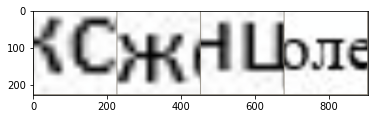

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-5.8477, -5.1670,  0.6739,  9.2669])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.0105, -3.9039,  4.9144,  1.4830])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.2470, -5.0183, -1.2057,  7.8603])
Predict class - calibri, real class - verdana, probability (arial,calibri) - tensor([ 1.1263,  1.6357, -3.3661,  0.7417])


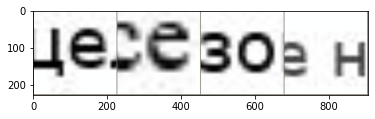

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.1767, -0.3908, -2.7088,  4.7454])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-4.1912, -1.0804, -3.7893,  7.7400])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.5452, -0.5487, -4.3208,  4.4751])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 1.0755, -1.2850, -5.6379,  4.9919])


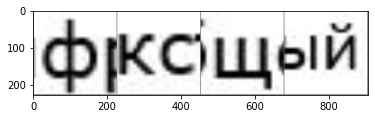

Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 1.9616,  1.3961, -3.2323, -0.6638])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 2.8197,  1.5833, -4.4077, -1.6492])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.7844,  3.3231, -3.4896,  0.5294])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.6277, -2.7378,  9.7700, -3.0540])


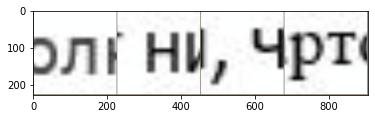

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.0236,  5.7297, -0.9186, -5.9507])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-4.1979, -1.7646,  9.9207, -2.2290])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.7543, -0.1287,  0.2183, -5.3374])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.5325,  5.5454, -0.6917, -3.9741])


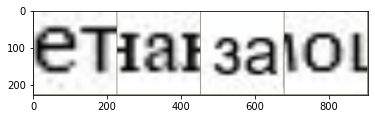

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.9459, -3.8898, -2.6797,  6.9300])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.1822,  5.2959,  0.6617, -5.5398])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.6618, -1.1977,  0.5092, -4.0421])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.9016,  3.6515, -0.5803, -3.8725])


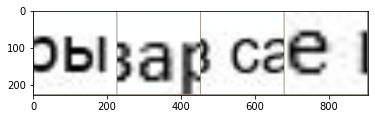

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.9375,  4.3102, -3.5918, -2.6890])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-1.1788,  5.3454,  0.1345, -3.6456])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.6149, -0.1765, -6.0894,  9.2480])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.6867,  5.4689, -3.0257, -1.9465])


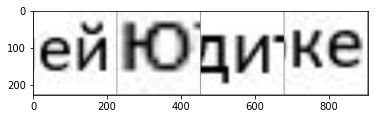

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 3.0843, -0.4136,  1.4093, -4.3176])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.0584, -1.2267, -3.3458,  5.2647])
Predict class - arial, real class - calibri, probability (arial,calibri) - tensor([ 4.2464,  0.7757, -0.2523, -5.0966])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-4.5722, -2.5826, -1.9471,  8.2108])


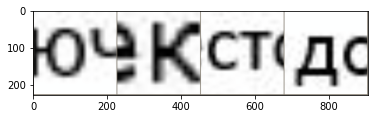

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.6152, -2.4837, -4.5823,  6.7689])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.8202,  1.9554, -3.4501, -0.0464])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.8580, -1.9374, -2.3175,  4.6742])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 1.9656, -1.7229,  3.6516, -3.3196])


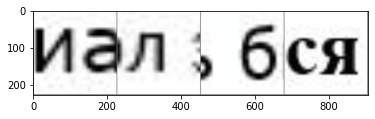

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-0.9486, -1.3619, 10.8846, -6.0734])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.5350,  2.9993, -7.1625,  3.1927])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.6997, -1.6263, -0.1267, -2.9412])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 2.3556, -2.3103,  4.0014, -3.7635])


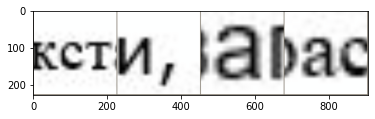

Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 2.7086,  0.0130, -1.1306, -1.4568])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.3759,  4.9051, -0.7667, -5.3057])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.2569,  5.1937, -0.0623, -5.7888])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([  1.0839,   8.0447,   1.8364, -10.6147])


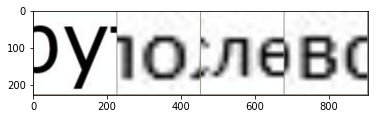

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.3236,  3.2687, -0.2777, -7.0577])
Predict class - arial, real class - calibri, probability (arial,calibri) - tensor([ 3.3525,  2.1500, -1.8044, -3.9108])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.1852,  3.8898, -9.9468,  6.6066])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.3124,  3.6108, -1.3975, -4.0207])


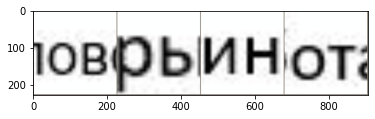

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.3491, -0.9213,  6.8974, -2.2084])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.2004,  6.6996,  0.9080, -8.3419])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 4.5064,  6.0388, -3.8611, -6.3830])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.9482, -0.7378, -3.9192,  4.9708])


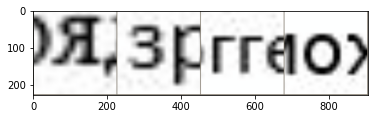

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.3376,  1.6479, -8.9149,  5.2265])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.3044,  6.4053,  0.4816, -8.8818])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 2.3002,  1.6931,  5.3105, -8.7536])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 2.2507,  1.8178, -4.5721, -1.0378])


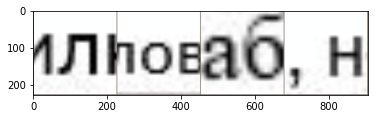

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.5197,  0.9376, -1.8386, -4.2634])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.6517, -6.1875,  1.6263,  6.7118])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.9906, -3.5028, -0.6812,  5.9975])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.3622,  5.6944, -8.3890,  0.9748])


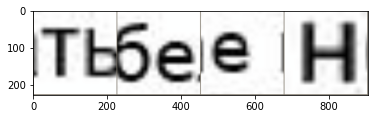

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.5778, -0.7537, -2.8058,  6.9532])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-4.5518, -2.7538, 10.4043, -2.5230])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 1.1819,  1.6499, -9.7659,  5.4483])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.2069, -2.4646,  7.7635, -0.8104])


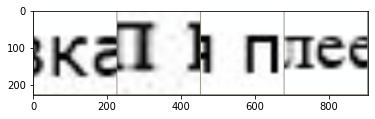

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([  2.2058,   2.6358, -10.7040,   3.9180])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.0783,  2.6192, -4.2803, -0.8351])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.3587,  0.2889, -1.2468, -3.2194])
Predict class - times new roman, real class - calibri, probability (arial,calibri) - tensor([ 0.7270, -1.2207,  3.0889, -2.6004])


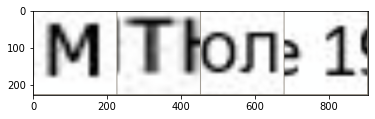

Predict class - calibri, real class - arial, probability (arial,calibri) - tensor([ 1.1080,  2.4944, -6.6649,  1.4197])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.1622,  3.6046,  1.9060, -5.5471])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.1082, -2.0072, -0.4160, -2.7137])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.1194,  4.0606,  0.2056, -4.9631])


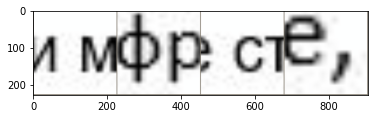

Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 3.1415,  0.2662, -1.9512, -1.4543])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-0.4060, -1.0692,  8.2330, -5.1955])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 3.2060,  4.1129, -2.2843, -4.3821])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.5361,  1.4121, -3.8655,  4.6797])


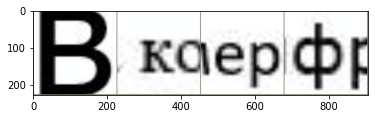

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.8126,  5.6851, -0.0401, -6.9867])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.7331,  4.1481,  2.5255, -5.8259])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 0.0738,  0.7959,  5.8269, -5.7171])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 2.7644,  0.9284, -0.7156, -2.9365])


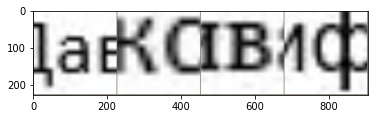

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 3.6606,  1.4296, -0.6137, -4.5206])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.0495,  4.7461,  2.7580, -7.2692])
Predict class - calibri, real class - verdana, probability (arial,calibri) - tensor([ 0.8416,  1.8194, -0.3504, -1.8719])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 3.0627,  1.7297, -6.7406,  1.2742])


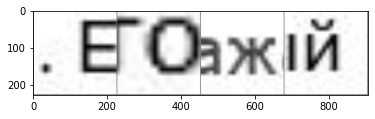

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.6754, -1.8987, -4.1283,  6.0042])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 2.9884, -2.7636,  0.4854, -1.8781])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 0.5969,  0.1660,  4.4819, -4.4244])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.9738,  1.0329, -5.7184,  6.3721])


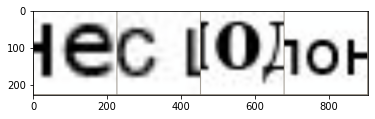

Predict class - times new roman, real class - verdana, probability (arial,calibri) - tensor([ 0.4414,  0.0715,  1.1918, -1.7723])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.3840, -0.5017, -3.6451,  5.0705])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 2.0160,  1.4218,  2.6665, -5.9080])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 5.0251,  1.0222, -3.7131, -2.3016])


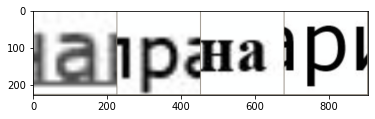

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.0375,  5.0603, -4.2849, -1.9120])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-5.7983, -0.8211, -1.3306,  6.6427])


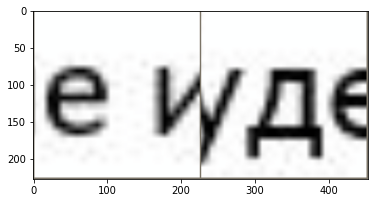

Accuracy of the network on the 134 test images: 87 %


In [14]:
# Visualization results of analysis test data
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format( printclass[0],printclass[1],
                                                                              classes[0], classes [1],printdata[2]))

        total += labels.size(0)
        correct += int((predicted == labels).int().sum())
        imshow_resNet18(torchvision.utils.make_grid(images))
        #print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('Accuracy of the network on the', dataset_sizes['test'], 'test images: %d %%' % (
    100 * correct / total))

In [15]:
'''# Export model to onnx format
PATH =os.path.join(dir, "my_resnet18.onnx")
dummy_input = Variable(torch.randn(1, 3, 224, 224))
torch.onnx.export(model_ft, dummy_input, PATH)'''

'# Export model to onnx format\nPATH =os.path.join(dir, "my_resnet18.onnx")\ndummy_input = Variable(torch.randn(1, 3, 224, 224))\ntorch.onnx.export(model_ft, dummy_input, PATH)'

PTH

In [16]:
#Save and load model
PATH =os.path.join('/content/', "my_model.pth")
torch.save(net.state_dict(), PATH)
#load
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Pickle

In [17]:
 # Save a dictionary into a pickle file.
import pickle
pickle.dump(model_ft, open("model.pcl", "wb"))

In [18]:
model = pickle.load(open("model.pcl", "rb"))

In [19]:
#model

Input for predict

In [20]:
#!rm -R .ipynb_checkpoints
#!ls -a  

In [21]:
#Create function to get your(my) images dataset and resize it to size for model
def get_dataset(data_dir, data_transforms):
    
    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['valid']}
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['valid']}

    return dataloaders['valid']

In [22]:
data_dir = '/content/drive/MyDrive/datasets'
dataloaders_test = get_dataset(data_dir, data_transforms)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [23]:
correct = 0 
total = 0 

for data in dataloaders_test:
        
        images, labels = data
        print(labels)
        outputs = model(images)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        #print(torch.max(outputs.data, 1))
        
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format( printclass[0],printclass[1],
                                                                              classes[0], classes [1],printdata[2]))
            
        total += labels.size(0)
        correct += int((predicted == labels).int().sum())
        #imshow_resNet18(torchvision.utils.make_grid(images))
        #print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

print('Accuracy of the network: {}'.format(correct / total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([1, 3, 1, 3])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.2844,  4.1151, -1.5749, -2.1069], grad_fn=<UnbindBackward0>)
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.3394, -2.3590, -4.6132,  7.9924], grad_fn=<UnbindBackward0>)
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.6287,  6.8628,  1.4495, -7.2847], grad_fn=<UnbindBackward0>)
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.8681,  0.8288, -4.7538,  2.1824], grad_fn=<UnbindBackward0>)
tensor([0, 3, 1, 1])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 6.8756,  0.3930, -3.7268, -3.9034], grad_fn=<UnbindBackward0>)
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.9745, -6.5408,  0.6653,  7.0616], grad_fn=<UnbindBackward0>)
Predict class - calibri, real class - calibri, probability (arial,ca

Preprocess img

In [24]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [25]:
#'/content/arial.png'
def preprocess_input(image_pth):

  test_img = Image.open(image_pth).convert('RGB')
  transformed_img = transform(test_img)
  input_img = transform_normalize(transformed_img)
  
  return input_img.unsqueeze(0) # the model requires a dummy batch dimension

In [26]:
#0-arial, 1-calibri, 2-tnr, 3-verdana
def pred_font(outputs):
  if (model(input_img) == model(input_img).max().item()).nonzero()[0][1] == torch.tensor(0):
    return 'arial'
  elif (model(input_img) == model(input_img).max().item()).nonzero()[0][1] == torch.tensor(1):
    return 'calibri'
  elif (model(input_img) == model(input_img).max().item()).nonzero()[0][1] == torch.tensor(2):
    return 'times new roman'
  else:
    return 'verdana'

In [27]:
image_pth = '/content/drive/MyDrive/datasets/valid/verdana/5.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img))          

'verdana'

In [28]:
image_pth = '/content/drive/MyDrive/datasets/valid/arial/2.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img)) 

'arial'

In [29]:
image_pth = '/content/drive/MyDrive/datasets/valid/times new roman/5.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img))       

'times new roman'

In [32]:
image_pth = '/content/drive/MyDrive/datasets/valid/times new roman/2.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img))      

'times new roman'